In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf
from sklearn import preprocessing
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [2]:
# Load waffle data_labels
df_foxes = pd.read_csv('/home/amit/AmitKushwaha/Courses/Books/StatisticalRethinkingBook/Data/foxes.csv',sep=';')
df_foxes = df_foxes.dropna()

In [3]:
df_foxes.head(20).style.bar(subset=['avgfood'], color='lightgreen').bar(subset=['groupsize'], color='red').bar(subset=['area'], color='yellow').bar(subset='weight', color='blue')

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85
5,3,0.49,2,2.12,3.25
6,4,0.45,2,1.29,4.53
7,4,0.45,2,1.29,4.09
8,5,0.74,3,3.78,6.13
9,5,0.74,3,3.78,5.59


## Model 1 : weight ~ area

In [42]:
def plot_regressions(df_foxes, xcol, ycol, credible_interval=.95, plot_name='hpd'):
    scaler = preprocessing.StandardScaler()
    yval = np.squeeze(scaler.fit_transform(df_foxes[ycol].values.reshape(-1,1)))
    xval = np.squeeze(scaler.fit_transform(df_foxes[xcol].values.reshape(-1,1)))
    
    with pm.Model() as model_1:
        a = pm.Normal('a', mu=10, sigma=10)
        ba = pm.Normal('ba', mu=0, sigma=1)
        sigma = pm.Uniform('sigma', lower=0, upper=10)
        mu = pm.Deterministic('mu', a + ba*xval)
        h = pm.Normal('h', mu=mu, sigma=sigma, observed=yval)
        map_1 = pm.find_MAP()
        trace_1 = pm.sample(cores=2)
    
    if plot_name=='forest':
        az.plot_forest(trace_1, var_names=['a','ba','sigma'], figsize=(6,6), credible_interval=credible_interval)
    
    if plot_name=='hpd':
        fig, ax = plt.subplots(figsize=(6,6))
        mu_mean = trace_1['mu']
        ax.scatter(xval, yval)
        ax.plot(xval, mu_mean.mean(0), 'C1')

        seq = np.linspace(np.min(xval), np.max(xval), 50)
        mu_pred = trace_1['a'] + trace_1['ba'] * seq[:,None]
        ax.plot(seq, mu_pred.mean(1), 'k.')
        az.plot_hpd(seq, mu_pred.T,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax, credible_interval=credible_interval)
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)
    
    if plot_name=='summary':
        print(az.summary(trace_1, ['a','ba','sigma'], credible_interval=credible_interval).round(3))


/home/amit/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -204.33, ||grad|| = 161.35: 100%|██████████| 30/30 [00:00<00:00, 2320.54it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ba, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1081.00draws/s]
The acceptance probability does not match the target. It is 0.883581613017141, but should be close to 0.8. Try to increase the number of tuning steps.


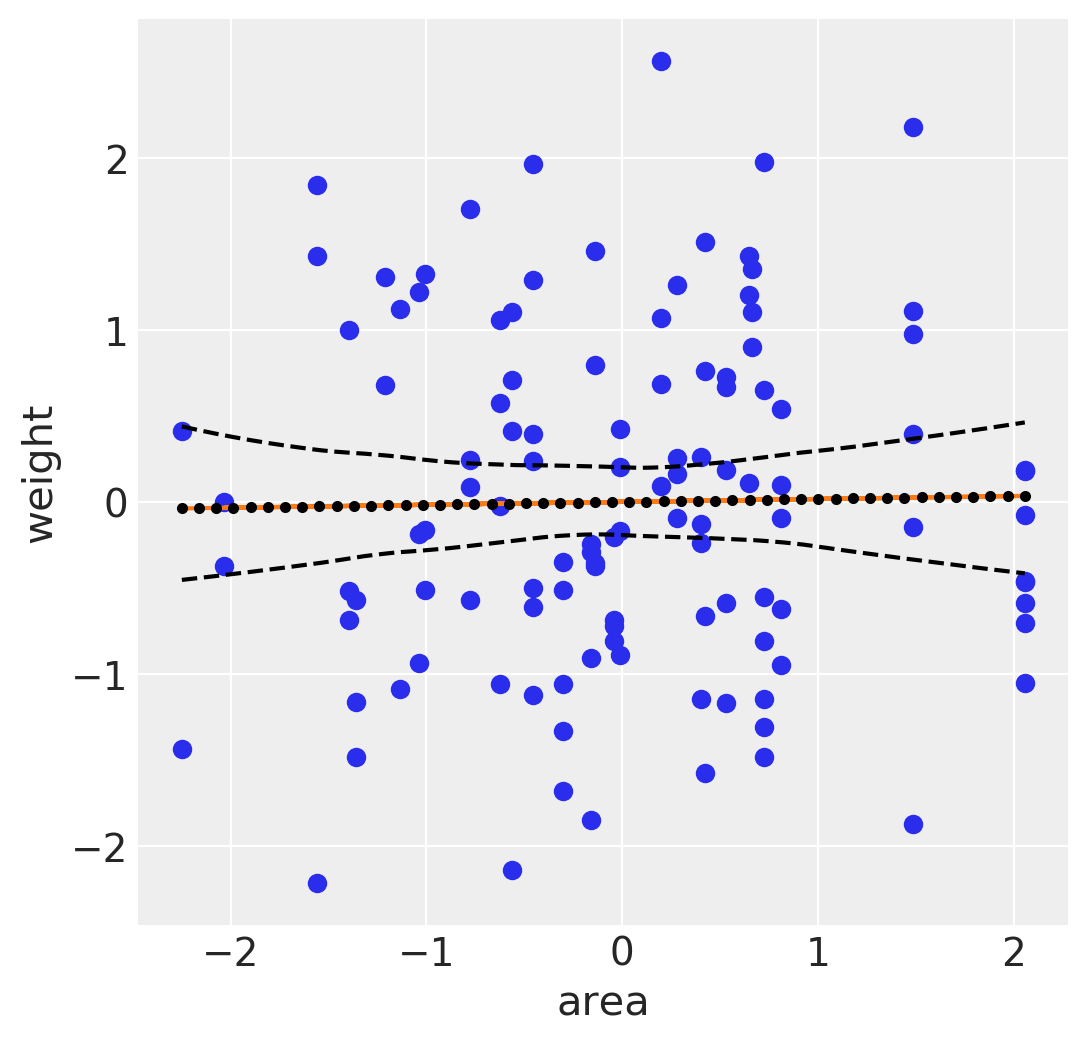

In [44]:
plot_regressions(df_foxes, 'area', 'weight')

/home/amit/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -181.52, ||grad|| = 50.245: 100%|██████████| 30/30 [00:00<00:00, 1685.34it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, ba, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1317.44draws/s]


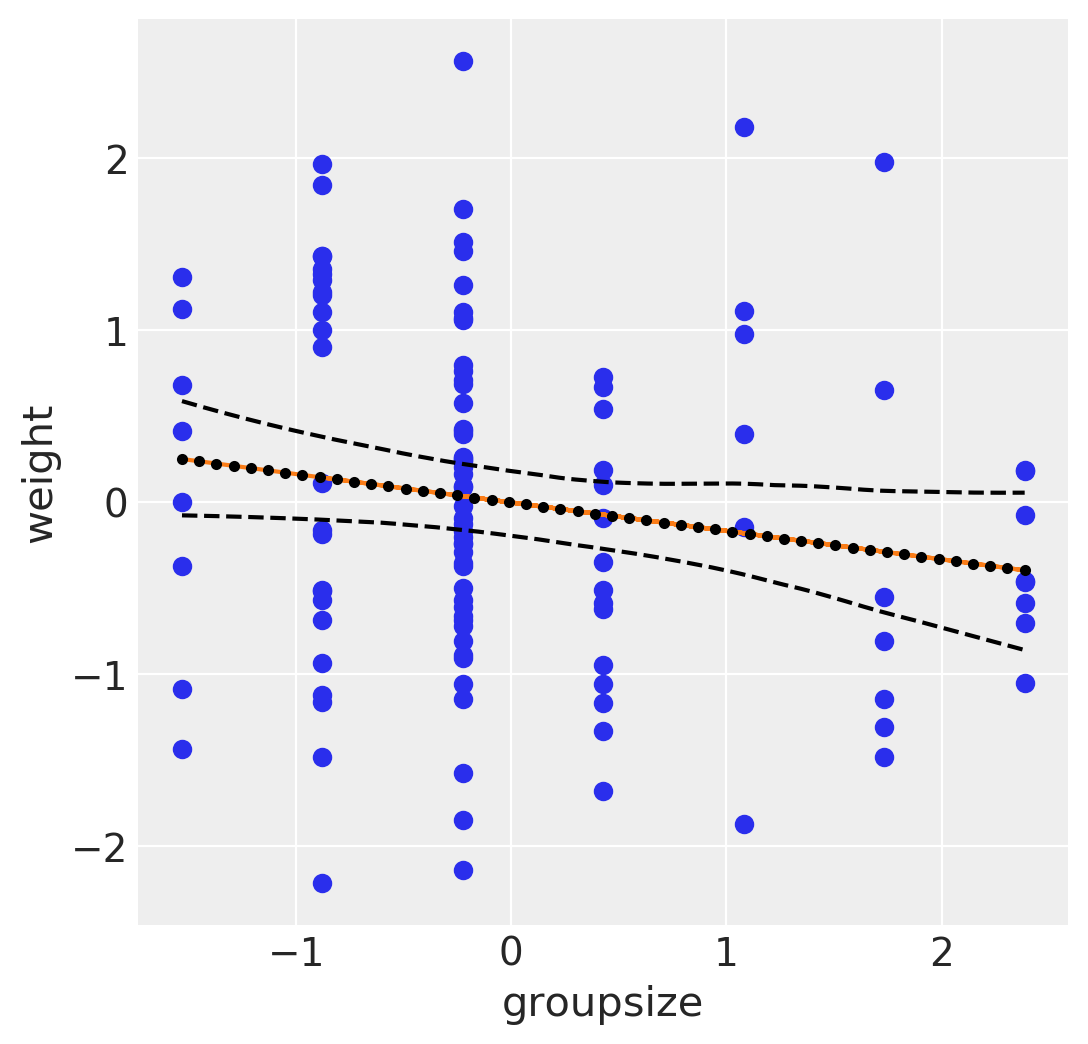

In [45]:
plot_regressions(df_foxes, 'groupsize', 'weight')

## Conclusion

The credible intervals for both groupsize and area for the slope include zero, so neither variable seems important for predicting the fox body weight